In [2]:
import pandas as pd

In [135]:
from scipy.optimize import minimize
from scipy.optimize import Bounds, NonlinearConstraint

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
from scipy.optimize import rosen, shgo, dual_annealing, least_squares, differential_evolution

In [7]:
File = pd.ExcelFile('tarea_opt_nolineal.xlsx')

In [8]:
print(File.sheet_names)

['Hoja1']


In [9]:
df=File.parse('Hoja1')

In [10]:
df=df[2:15]

In [11]:
df=df.transpose()

In [12]:
df=df[1:184]

In [13]:
df

,2,3,4,5,6,7,8,9,10,11,12,13,14
Unnamed: 1,Fecha,Infectados (casos diarios),Infectados (total acumulados),recuperados (casos diarios),recuperados (total acumulados),fallecidos (casos diarios),fallecidos (total acumulados),infectados asintomaticos (casos diarios),infectados asintomaticos (total acumulados),Activos confirmados (diario),activos no confirmados (diario),tasa asintomatico_2 (diario),tasa asintomatico (diario)
Unnamed: 2,2020-12-01 00:00:00,1119,552864,1430,528034,20,15430,354,92828,9089,1748,0.161299,0.316354
Unnamed: 3,2020-12-02 00:00:00,1035,553899,1467,529501,8,15438,245,93073,8647,1865,0.177416,0.236715
Unnamed: 4,2020-12-03 00:00:00,1507,555406,969,530470,81,15519,409,93482,9104,1999,0.180041,0.2714
Unnamed: 5,2020-12-04 00:00:00,1729,557135,1073,531543,39,15558,552,94034,9719,2044,0.173765,0.31926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unnamed: 179,2021-05-27 00:00:00,8117,1352087,5542,1282561,185,28809,1852,300233,40510,12548,0.236496,0.228163
Unnamed: 180,2021-05-28 00:00:00,8680,1360767,5243,1287804,119,28928,2238,302471,43793,13104,0.230311,0.257834
Unnamed: 181,2021-05-29 00:00:00,8426,1369193,7842,1295646,119,29047,2115,304586,44186,13071,0.228286,0.251009
Unnamed: 182,2021-05-30 00:00:00,7772,1376965,6872,1302518,121,29168,2012,306598,44928,13238,0.22759,0.258878


In [14]:
fechas=df.iloc[:,0]
fechas=fechas.iloc[1:len(fechas)]#dias considerados

In [15]:
Ib=df.iloc[:,1]
Ib=Ib.iloc[1:len(Ib)]#casos nuevos totales

In [16]:
Rb=df.iloc[:,3]
Rb=Rb.iloc[1:len(Rb)]#total de recuperados diarios


In [17]:
Db=df.iloc[:,5]
Db=Db.iloc[1:len(Db)]#total de muertos diarios


In [18]:
Ab=df.iloc[:,7]
Ab=Ab.iloc[1:len(Ab)]#total de infectados asintomaticos diarios
Ib_ac=df.iloc[:,2]
Ib_ac=Ib_ac.iloc[1:len(Ib_ac)]#total de infectados acumulados
Rb_ac=df.iloc[:,4]
Rb_ac=Rb_ac.iloc[1:len(Rb_ac)]#total de recuperados acumulados (R en el modelo SEAIRD)
Db_ac=df.iloc[:,6]
Db_ac=Db_ac.iloc[1:len(Db_ac)]#total de muertos acumulados (D en el modelo SEAIRD)

In [19]:
Ab_ac=df.iloc[:,8]
Ab_ac=Ab_ac.iloc[1:len(Ab_ac)]#total de infectados asintomaticos acumulados

In [20]:
ac_con=df.iloc[:,9]
ac_con=ac_con.iloc[1:len(ac_con)]#casos activos confirmados diarios (I en el modelo SEAIRD)
ac_sin=df.iloc[:,10]
ac_sin=ac_sin.iloc[1:len(ac_sin)]#casos activos no confirmados diarios (A en el modelo SEAIRD)

In [21]:
kappa=ac_sin/ac_con #Proporcion de test (parametro k=activos no confirmados/activos confirmados) en el modelo SEAIRD

In [22]:
N=19107000;#poblacion total
n=len(Ib);#numero de dias considerados
largo=7 #duracion en dias de las medidas tomadas (distancamiento social y cuarentena)
num=int(n/largo);#tamaño de los vectores alpha_a y alpha_i

In [23]:
Rb_act_ac=Rb_ac-(Rb_ac[0]-Rb[0])*np.ones(n)

In [45]:
np.random.seed(0)
alpha_a=np.random.rand(num)
alpha_i=np.random.rand(num)
alpha_a[0]=0.5
alpha_i[0]=0.5
mu0=(Db_ac[1]-Db_ac[0])/ac_con[0]
beta0=(Rb_ac[1]-Rb_ac[0]-0.1*ac_sin[0])/ac_con[0]
E0=(ac_sin[1]-(0.9-kappa[0])*ac_sin[0])/0.5
#(1-beta-mu)*ac_con[0]+kappa[0]*ac_sin[0]
#ac_con[1]
E1=(ac_sin[2]-(0.9-kappa[1])*ac_sin[1])/0.5
delta=(alpha_a[0]*ac_sin[0]+alpha_i[0]*ac_con[0])/N
S0=(E1-0.5*E0)/delta
mu0=np.ones(1)*mu0
beta0=np.ones(1)*beta0
x0=np.concatenate((mu0,beta0,alpha_a,alpha_i))

In [46]:

def fun_aux(x):#x debe ser un vector que acople los parametros mu, beta, alpha_a y alpha_i (en ese orden)
    mu=x[0];
    beta=x[1];
    alpha_a=x[2:num+2];
    alpha_i=x[num+2:2*num+2];
    I=np.zeros(n);
    D=np.zeros(n);
    R=np.zeros(n);
    A=np.zeros(n);
    S=np.zeros(n);
    E=np.zeros(n);
    new_alpha_a=np.repeat(alpha_a[0],largo)#new_alpha_a es el parametro de distanciamiento social,
                                            #la cual es una funcion escalon
    new_alpha_i=np.repeat(alpha_i[0],largo)#new_alpha_i es el parametro de cuarentena, la cual es una funcion escalon
    I[0]=ac_con[0]
    R[0]=Rb_ac[0]
    D[0]=Db_ac[0]
    A[0]=ac_sin[0]
    E[0]=E0
    S[0]=S0
    for j in range(1,num):
        aux_a=np.repeat(alpha_a[j],largo)
        aux_i=np.repeat(alpha_i[j],largo)
        new_alpha_a=np.concatenate((new_alpha_a,aux_a))
        new_alpha_i=np.concatenate((new_alpha_i,aux_i))
    for j in range(n-1):
        delta=(new_alpha_a[j]*A[j]+new_alpha_i[j]*I[j])/N;
        S[j+1]=(1-delta)*S[j];#gamma=0
        E[j+1]=0.5*E[j]+delta*S[j];
        A[j+1]=(0.9-kappa[j])*A[j]+0.5*E[j];
        I[j+1]=(1-beta-mu)*I[j]+kappa[j]*A[j];
        R[j+1]=R[j]+0.1*A[j]+beta*I[j];#gamma=0
        D[j+1]=D[j]+mu*I[j];
    return I, R, D


In [47]:
PR=0;#peso asociado a los recuperados
PD=2/3;#peso asociado a los muertos
PI=1-PR-PD;#peso asociado a los infectados

In [48]:

def obj_fun(x):
    I, R, D= fun_aux(x);
    return PI*np.sum(np.square(I-ac_con))+PR*np.sum(np.square(R-Rb_ac))+PD*np.sum(np.square(D-Db_ac))

In [49]:
bounds= Bounds(0,1)

In [50]:
res = minimize(obj_fun, x0, method='trust-constr',
              options={'verbose': 1}, bounds=bounds)

C:\Users\sergi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 55385, CG iterations: 52857, optimality: 1.65e+05, constraint violation: 0.00e+00, execution time: 4e+02 s.


In [51]:
sol=res.x

In [52]:
sol

array([0.00277638, 0.06367201, 0.84490726, 0.68458236, 0.42008294,
       0.86297985, 0.91425092, 0.82814963, 0.37170083, 0.34838637,
       0.81286634, 0.31287092, 0.27546673, 0.10976284, 0.92371342,
       0.99983636, 0.42332072, 0.1685551 , 0.00951843, 0.65447439,
       0.4915587 , 0.6040647 , 0.87990726, 0.37130877, 0.63757385,
       0.98708703, 0.04196282, 0.93156886, 0.98034572, 0.61582534,
       0.74178861, 0.64642815, 0.86365967, 0.71153803, 0.51216577,
       0.69443647, 0.00533223, 0.75701109, 0.6151628 , 0.67238296,
       0.56828321, 0.69166381, 0.71349925, 0.83583557, 0.80812953,
       0.49066703, 0.6422104 , 0.41039044, 0.41380933, 0.42124991,
       0.56775896, 0.68489354, 0.8436827 , 0.97233806])

In [54]:
I, R, D=fun_aux(sol)


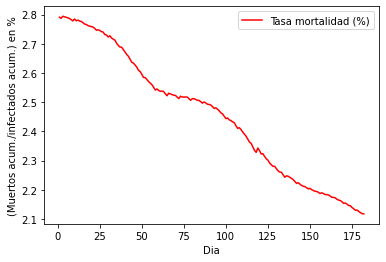

In [55]:
ejex=np.linspace(1,n,n)
tasa_mor=(Db_ac/Ib_ac)*100
plt.plot(ejex,tasa_mor,label='Tasa mortalidad (%)',color='red')
plt.xlabel('Dia')  # Add an x-label to the axes.
plt.ylabel('(Muertos acum./infectados acum.) en %')  # Add a y-label to the axes.
#plt.title('acumulados')  # Add a title to the axes.
plt.legend()  # Add a legend.

In [166]:
#cant=200
#fun_vec=np.zeros(cant)
#for l in range(cant):
#    alpha_a=np.random.rand(num)
#    alpha_i=np.random.rand(num)
#    mu=np.random.rand(1)
#    beta=np.random.rand(1)
#    x=np.concatenate((mu,beta,alpha_a,alpha_i))
#    fun_vec[l]=obj_fun(x)


In [64]:
lw = [0] * (2*num+2)
up = [1] * (2*num+2)
ret = dual_annealing(obj_fun, bounds=list(zip(lw, up)))
ret.x

array([0.00277676, 0.06255387, 0.61039239, 0.68826076, 0.90449303,
       0.59659857, 0.67612009, 0.49670614, 0.44899803, 0.67895828,
       0.46210794, 0.61592254, 0.61114175, 0.48688427, 0.52360272,
       0.573006  , 0.41214355, 0.52731061, 0.70251739, 0.45383493,
       0.56215424, 0.41901167, 0.48803513, 0.43969033, 0.61886689,
       0.50262285, 0.59115975, 1.        , 1.        , 0.65923651,
       0.49858128, 0.7736214 , 0.98261376, 0.8786359 , 0.4780674 ,
       0.54660523, 0.13745238, 0.643954  , 0.46931857, 0.51992648,
       0.70522751, 0.81543746, 0.7039931 , 0.72610463, 0.61817839,
       0.52890619, 0.61689101, 0.43817549, 0.47511553, 0.39876456,
       0.5597907 , 0.79081495, 0.67897826, 1.        ])

In [65]:
#bounds = [(0, 1.0), ]*(2*num+2)

In [66]:
#result = differential_evolution(obj_fun, bounds)

In [79]:
sol_2=ret.x

In [80]:
I2, R2, D2 = fun_aux(sol_2)
sol_2

array([0.00277676, 0.06255387, 0.61039239, 0.68826076, 0.90449303,
       0.59659857, 0.67612009, 0.49670614, 0.44899803, 0.67895828,
       0.46210794, 0.61592254, 0.61114175, 0.48688427, 0.52360272,
       0.573006  , 0.41214355, 0.52731061, 0.70251739, 0.45383493,
       0.56215424, 0.41901167, 0.48803513, 0.43969033, 0.61886689,
       0.50262285, 0.59115975, 1.        , 1.        , 0.65923651,
       0.49858128, 0.7736214 , 0.98261376, 0.8786359 , 0.4780674 ,
       0.54660523, 0.13745238, 0.643954  , 0.46931857, 0.51992648,
       0.70522751, 0.81543746, 0.7039931 , 0.72610463, 0.61817839,
       0.52890619, 0.61689101, 0.43817549, 0.47511553, 0.39876456,
       0.5597907 , 0.79081495, 0.67897826, 1.        ])

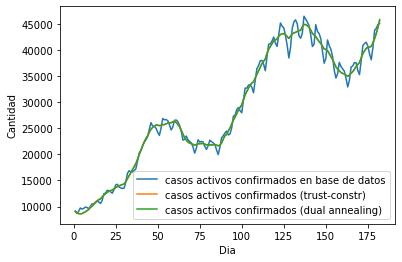

In [82]:
ejex=np.linspace(1,n,n)

plt.plot(ejex,ac_con,label='casos activos confirmados en base de datos')
plt.plot(ejex,I,label='casos activos confirmados (trust-constr)')
plt.plot(ejex,I2,label='casos activos confirmados (dual annealing)')
plt.xlabel('Dia')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
#plt.title('acumulados')  # Add a title to the axes.
plt.legend()  # Add a legend.


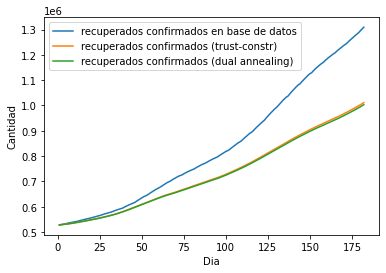

In [83]:
ejex=np.linspace(1,n,n)

plt.plot(ejex,Rb_ac,label='recuperados confirmados en base de datos')
plt.plot(ejex,R,label='recuperados confirmados (trust-constr)')
plt.plot(ejex,R2,label='recuperados confirmados (dual annealing)')
plt.xlabel('Dia')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
#plt.title('acumulados')  # Add a title to the axes.
plt.legend()  # Add a legend.

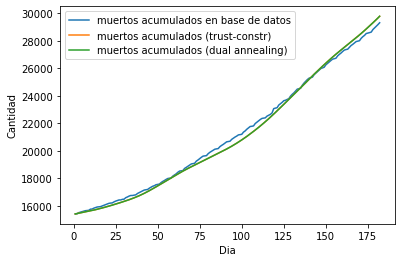

In [84]:
ejex=np.linspace(1,n,n)

plt.plot(ejex,Db_ac,label='muertos acumulados en base de datos')
plt.plot(ejex,D,label='muertos acumulados (trust-constr)')
plt.plot(ejex,D2,label='muertos acumulados (dual annealing)')
plt.xlabel('Dia')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
#plt.title('acumulados')  # Add a title to the axes.
plt.legend()  # Add a legend.

In [ ]:
###################DE AQUI EN ADELANTE ES LA P3###########################

In [283]:
n2=154#estudiamos los dias desde el 1 de mayo hasta el 1 de octubre para que la cantidad de dias sea multiplo de 7
largo2=7
num2=int(n2/largo2)
kappa2=np.concatenate((kappa,np.repeat(0.3,123)))
np.random.seed(0)
alpha_a=np.random.rand(num2)
alpha_i=np.random.rand(num2)
alpha_a[0]=0.5
alpha_i[0]=0.5
E02=(ac_sin[152]-(0.9-kappa[151])*ac_sin[151])/0.5
E12=(ac_sin[153]-(0.9-kappa[152])*ac_sin[152])/0.5
delta=(alpha_a[0]*ac_sin[151]+alpha_i[0]*ac_con[151])/N
S02=(E12-0.5*E02)/delta
kappa2=kappa2[151:305]
x0=np.concatenate((alpha_a,alpha_i))

In [284]:
def fun_aux2(x):#x debe ser un vector que acople los parametros alpha_a y alpha_i (en ese orden)
    mu=sol[0]
    beta=sol[1]
    alpha_a=x[:num2];
    alpha_i=x[num2:2*num2];
    I=np.zeros(n2);
    D=np.zeros(n2);
    R=np.zeros(n2);
    A=np.zeros(n2);
    S=np.zeros(n2);
    E=np.zeros(n2);
    new_alpha_a=np.repeat(alpha_a[0],largo2)#new_alpha_a es el parametro de distanciamiento social,
                                            #la cual es una funcion escalon
    new_alpha_i=np.repeat(alpha_i[0],largo2)#new_alpha_i es el parametro de cuarentena, la cual es una funcion escalon
    I[0]=ac_con[151]#numero de activos confirmados del 1 de mayo
    R[0]=Rb_ac[151]#numero de recuperados acumulados del 1 de mayo
    D[0]=Db_ac[151]#numero de muertos acumulados del 1 de mayo
    A[0]=ac_sin[151]#numero de activos no confirmados del 1 de mayo
    E[0]=E02
    S[0]=S02
    for j in range(1,num2):
        aux_a=np.repeat(alpha_a[j],largo2)
        aux_i=np.repeat(alpha_i[j],largo2)
        new_alpha_a=np.concatenate((new_alpha_a,aux_a))
        new_alpha_i=np.concatenate((new_alpha_i,aux_i))
    for j in range(n2-1):
        delta=(new_alpha_a[j]*A[j]+new_alpha_i[j]*I[j])/N;
        S[j+1]=(1-delta)*S[j];#gamma=0
        E[j+1]=0.5*E[j]+delta*S[j];
        A[j+1]=(0.9-kappa2[j])*A[j]+0.5*E[j];
        I[j+1]=(1-beta-mu)*I[j]+kappa2[j]*A[j];
        R[j+1]=R[j]+0.1*A[j]+beta*I[j];#gamma=0
        D[j+1]=D[j]+mu*I[j];
    return I

In [285]:
def fun_rest(x):
    I=fun_aux2(x)
    return max(I)

In [292]:
ca=100;
ci=100;
Ip=30000;

In [293]:
def obj_fun2(x):#x debe ser un vector que acople los parametros alpha_a y alpha_i (en ese orden)
    alpha_a=x[:num2];
    alpha_i=x[num2:2*num2];
    new_alpha_a=np.repeat(alpha_a[0],largo2)#new_alpha_a es el parametro de distanciamiento social,
                                            #la cual es una funcion escalon
    new_alpha_i=np.repeat(alpha_i[0],largo2)
    for j in range(1,num2):
        aux_a=np.repeat(alpha_a[j],largo2)
        aux_i=np.repeat(alpha_i[j],largo2)
        new_alpha_a=np.concatenate((new_alpha_a,aux_a))
        new_alpha_i=np.concatenate((new_alpha_i,aux_i))
    return ca*np.sum(np.ones(n2)-new_alpha_a)+ci*np.sum(np.ones(n2)-new_alpha_i)

In [294]:
fun_rest(x0)

42705.77941701273

In [295]:
bounds= Bounds(0,1)

In [296]:
nonlinear_constraint = NonlinearConstraint(fun_rest, -np.inf, Ip)

In [297]:
res2 = minimize(obj_fun2, x0, method='trust-constr', constraints=[nonlinear_constraint],
               options={'verbose': 1}, bounds=bounds)

The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 59760, CG iterations: 5080, optimality: 7.55e+01, constraint violation: 1.26e+04, execution time: 2.1e+02 s.


In [298]:
sol_p3=res2.x

In [299]:
sol_p3

array([0.99979385, 0.99984753, 0.99982525, 0.99983285, 0.99982342,
       0.99981649, 0.99981377, 0.99982371, 0.99982566, 0.99982277,
       0.9998251 , 0.99982353, 0.99982102, 0.999838  , 0.99987787,
       0.99987698, 0.99988109, 0.99985694, 0.99987702, 0.99987887,
       0.99987881, 0.99987941, 0.09231022, 0.99507113, 0.97334593,
       0.96115576, 0.98041223, 0.71907798, 0.77055005, 0.97584781,
       0.98119908, 0.7817132 , 0.55294467, 0.82937627, 0.98806478,
       0.99873948, 0.99990862, 0.99991266, 0.99991289, 0.99990443,
       0.99998796, 0.99998447, 0.99997329, 0.99988848])

In [300]:
I=fun_aux2(sol_p3)

In [301]:
len(I[:31])

31

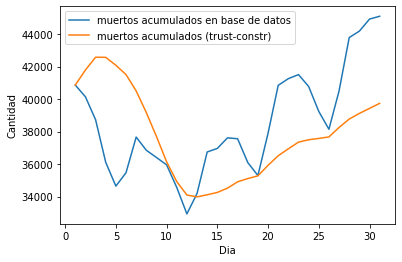

In [302]:
ejex=np.linspace(1,31,31)

plt.plot(ejex,ac_con[151:182],label='muertos acumulados en base de datos')
plt.plot(ejex,I[:31],label='muertos acumulados (trust-constr)')
#plt.plot(ejex,D2,label='muertos acumulados (dual annealing)')
plt.xlabel('Dia')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
#plt.title('acumulados')  # Add a title to the axes.
plt.legend()  # Add a legend.